In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/temprel.csv')

In [3]:
df.pop('timestamp')
#Create a copy of dataset
data_imputed = df.copy()

# Define the imputation model
imputer = IterativeImputer(max_iter=10, random_state=0)
# Define the number of imputations
n_imputations = 5

In [4]:
for i in range(n_imputations):
    # Impute missing values using the MICE algorithm
    data_imputed.iloc[:, :] = imputer.fit_transform(data_imputed)

    # Store the imputed values in a new dataframe
    data_imputed_i = pd.DataFrame(imputer.transform(df),
                                   columns=df.columns)

    # Merge the imputed values with the original dataset
    data_imputed = data_imputed.combine_first(data_imputed_i)

In [5]:
data_imputed.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2357.0000,2357.0000,2321.6001,2336.35010,2336.3501,127318.0,0.0,1.0
1,2357.3501,2370.8000,2334.0500,2355.39990,2355.3999,88852.0,0.0,1.0
2,2311.3000,2359.6001,2307.1499,2351.80000,2351.8000,268850.0,0.0,1.0
3,2312.0000,2327.0000,2293.1001,2306.00018,2305.8999,225094.0,0.0,1.0
4,2325.0000,2325.0000,2306.7500,2311.50000,2311.5000,206263.0,0.0,1.0


In [6]:
# Create a new dataframe with only the 'Close' column 
data = data_imputed.filter(['close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .6 ))

window_size = 60
training_data_len

2679

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# create scaler
scaler = StandardScaler()
# fit and transform in one step
scaled_data = scaler.fit_transform(dataset)

print ('scaled_data.shape',len(scaled_data))
scaled_data

scaled_data.shape 4464


array([[ 1.6424274 ],
       [ 1.67335268],
       [ 1.66750863],
       ...,
       [-1.50730654],
       [-1.50621416],
       [-1.49128724]])

In [8]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len)]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i<= window_size + 1:
        print('x_train',x_train)
        print('\ny_train',y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print ('x_train.shape:',x_train.shape)

x_train [array([1.6424274 , 1.67335268, 1.66750863, 1.59315759, 1.60208595,
       1.63057648, 1.62692384, 1.645187  , 1.66396628, 1.66669694,
       1.64469998, 1.71807728, 1.77035033, 1.79380866, 1.81507493,
       1.86117942, 1.86686129, 1.87327352, 1.81832171, 1.81483805,
       1.86280281, 1.94949176, 2.00217081, 2.06483373, 1.96856661,
       1.93001106, 1.93755967, 2.00062859, 2.03009299, 1.98634275,
       1.97717058, 1.98025503, 1.98122906, 1.94786836, 1.91061153,
       2.03455731, 2.04510936, 2.104769  , 2.0423784 , 2.01377823,
       2.03593736, 2.0946228 , 2.10972051, 2.08473843, 2.08520746,
       2.15079232, 2.15144151, 2.21369874, 2.20493259, 2.26954325,
       2.27003043, 2.28537132, 2.25071207, 2.24584189, 2.09811326,
       2.04210625, 1.99973573, 2.01247935, 1.99360064, 2.06645712])]

y_train [2.072544839979065]

x_train [array([1.6424274 , 1.67335268, 1.66750863, 1.59315759, 1.60208595,
       1.63057648, 1.62692384, 1.645187  , 1.66396628, 1.66669694,
       1.644

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(x_train.shape[1], 1), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(25 , activation="relu", name ="dense_1")(x)
    
    output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_model = build_LSTM_model()
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 60, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 25)                3225      
                                                                 
 last_dense (Dense)          (None, 1)                 26        
                                                                 
Total params: 300,723
Trainable params: 300,723
Non-trainable

In [10]:
y_train

array([ 2.07254484,  2.05720395,  2.08131115, ..., -0.9356813 ,
       -0.97366883, -0.97188293])

In [11]:
epochs = 50
batch_size = 500
early_stopping_patience = 17


# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = LSTM_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
6/6 [==============================] - 14s 48ms/step - loss: 0.4677
Epoch 2/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0917
Epoch 3/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0550
Epoch 4/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0347
Epoch 5/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0282
Epoch 6/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0220
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0183
Epoch 8/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0150
Epoch 9/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0129
Epoch 10/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0109
Epoch 11/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0105
Epoch 12/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0101
Epoch 13/50
6/6 [==============================] - 0s 32ms/s

dict_keys(['loss'])


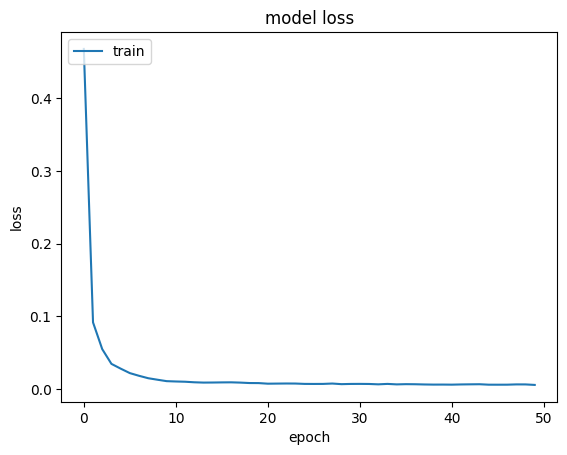

In [12]:
# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [13]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window_size: ]
print ('len(test_data):', len(test_data))

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = LSTM_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


len(test_data): 1845
56/56 [==============================] - 2s 7ms/step


<ipython-input-14-6511bb59e7ba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


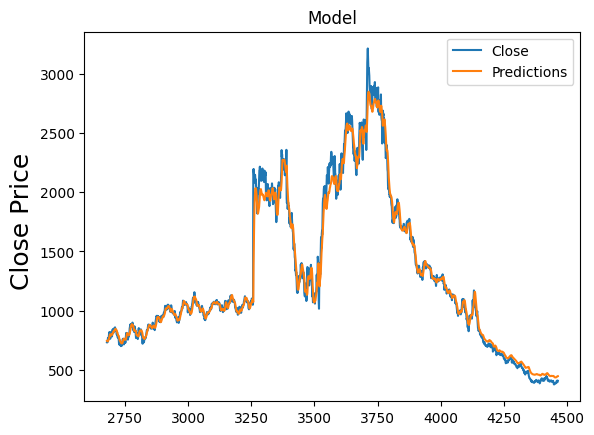

In [14]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure()
plt.title('Model')
plt.ylabel('Close Price ', fontsize=18)
#plt.plot(train['Close'])
plt.plot(test[['close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(test['Predictions'],y_test)
mse = mean_squared_error(test['Predictions'], y_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Predictions'],y_test)
r = r2_score(test['Predictions'], y_test)

In [16]:
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)
print('R-Squared Score = {}'.format(r))

Mean Absolute Error: 47.45919223581141
Mean Squared Error: 6289.904885413877
Root Mean Squared Error: 79.30892059165777
Mean Absolute Percentage Error: 0.03874725695010425
R-Squared Score = 0.9836612766021301
